In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import googlenet
from torchvision.models import resnet18
from torchvision.models import efficientnet_b0




# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the number of classes and samples per class
num_classes = 10
samples_per_class = 2000

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 dataset and loaders
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Get the targets (labels) from the CIFAR-10 dataset
targets = np.array(train_dataset.targets)

# Initialize a list to store the indices for the balanced subset
balanced_indices = []

# Loop through each class and select 1000 samples per class
for class_idx in range(num_classes):
    class_indices = np.where(targets == class_idx)[0]
    # Randomly select 2000 indices for each class
    chosen_indices = np.random.choice(class_indices, samples_per_class, replace=False)
    balanced_indices.extend(chosen_indices)

# Create a balanced subset of the CIFAR-10 dataset
balanced_train_dataset = Subset(train_dataset, balanced_indices)


train_loader = DataLoader(dataset=balanced_train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,   batch_size=100, shuffle=False)

# LeNet Model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Modified AlexNet Model for CIFAR-10
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 2 * 2, 4096)  # Default size for 32x32 CIFAR images
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Dynamically calculate the size of the flattened input for the FC layer
        x = x.view(x.size(0), -1)

        # If fc1 input size doesn't match dynamically, adjust it
        if x.size(1) != self.fc1.in_features:
            self.fc1 = nn.Linear(x.size(1), 4096).to(device)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




# VGG Model
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1),
                       nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.model = googlenet(pretrained=False, aux_logits=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.model = resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)



class EfficientNet(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNet, self).__init__()
        self.model = efficientnet_b0(pretrained=False)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)






vgg_cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']


100%|██████████| 170M/170M [00:05<00:00, 28.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
def train_model(model, optimizer, criterion, num_epochs=5, model_name="Model"):
    # Move the model to the device (GPU/CPU)
    model = model.to(device)

    print(f"Training {model_name} architecture:")
    print(model)

    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs} for {model_name}")
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0

        for inputs, labels in train_loader:
            # Move inputs and labels to the device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device) # Move data to the same device as the model

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc_history.append(100 * correct / total)
        train_loss_history.append(running_loss / total)

        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move inputs and labels to the device (GPU/CPU)
                inputs, labels = inputs.to(device), labels.to(device) # Move data to the same device as the model
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc_history.append(100 * correct / total)
        val_loss_history.append(val_loss / total)

    return train_acc_history, train_loss_history, val_acc_history, val_loss_history


# Initialize models, optimizers, and criterion
lenet = LeNet()
alexnet = AlexNet()
vgg = VGG(make_layers(vgg_cfg))

criterion = nn.CrossEntropyLoss()

optimizer_lenet = optim.Adam(lenet.parameters(), lr=0.001)
optimizer_alexnet = optim.Adam(alexnet.parameters(), lr=0.001)
optimizer_vgg = optim.Adam(vgg.parameters(), lr=0.001)


# Number of epochs.
num_epochs = 20

# Train and evaluate each model
train_acc_lenet, train_loss_lenet, val_acc_lenet, val_loss_lenet = train_model(lenet, optimizer_lenet, criterion, model_name="LeNet",num_epochs=num_epochs)
train_acc_alexnet, train_loss_alexnet, val_acc_alexnet, val_loss_alexnet = train_model(alexnet, optimizer_alexnet, criterion, model_name="AlexNet",num_epochs=num_epochs)
train_acc_vgg, train_loss_vgg, val_acc_vgg, val_loss_vgg = train_model(vgg, optimizer_vgg, criterion, model_name="VGG",num_epochs=num_epochs)


Training LeNet architecture:
LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 1/20 for LeNet
Epoch 2/20 for LeNet
Epoch 3/20 for LeNet
Epoch 4/20 for LeNet
Epoch 5/20 for LeNet
Epoch 6/20 for LeNet
Epoch 7/20 for LeNet
Epoch 8/20 for LeNet
Epoch 9/20 for LeNet
Epoch 10/20 for LeNet
Epoch 11/20 for LeNet
Epoch 12/20 for LeNet
Epoch 13/20 for LeNet
Epoch 14/20 for LeNet
Epoch 15/20 for LeNet
Epoch 16/20 for LeNet
Epoch 17/20 for LeNet
Epoch 18/20 for LeNet
Epoch 19/20 for LeNet
Epoch 20/20 for LeNet
Training AlexNet architecture:
AlexNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(192, 384, kernel_

In [3]:
# Initialize models
googlenet_model = GoogLeNet()
resnet_model = ResNet()
efficientnet_model = EfficientNet()

# Move models to device
googlenet_model.to(device)
resnet_model.to(device)
efficientnet_model.to(device)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizers
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=0.001)


# Number of epochs
num_epochs = 20

# Train and evaluate GoogLeNet
train_acc_googlenet, train_loss_googlenet, val_acc_googlenet, val_loss_googlenet = train_model(
    googlenet_model, optimizer_googlenet, criterion, num_epochs=num_epochs, model_name="GoogLeNet"
)

# Train and evaluate ResNet
train_acc_resnet, train_loss_resnet, val_acc_resnet, val_loss_resnet = train_model(
    resnet_model, optimizer_resnet, criterion, num_epochs=num_epochs, model_name="ResNet"
)

# Train and evaluate EfficientNet
train_acc_efficientnet, train_loss_efficientnet, val_acc_efficientnet, val_loss_efficientnet = train_model(
    efficientnet_model, optimizer_efficientnet, criterion, num_epochs=num_epochs, model_name="EfficientNet"
)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Training GoogLeNet architecture:
GoogLeNet(
  (model): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1

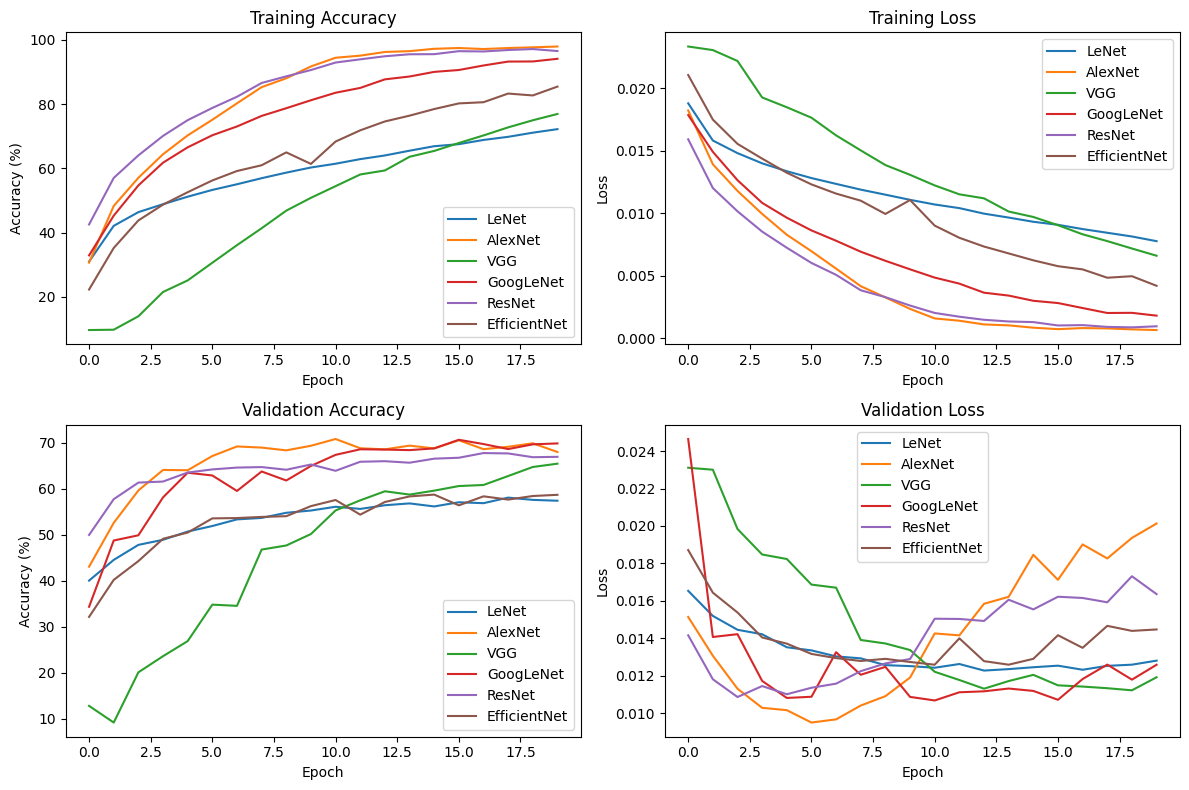

In [4]:
plt.figure(figsize=(12, 8))

# Training Accuracy
plt.subplot(2, 2, 1)
plt.plot(train_acc_lenet, label='LeNet')
plt.plot(train_acc_alexnet, label='AlexNet')
plt.plot(train_acc_vgg, label='VGG')
plt.plot(train_acc_googlenet, label='GoogLeNet')
plt.plot(train_acc_resnet, label='ResNet')
plt.plot(train_acc_efficientnet, label='EfficientNet')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Loss
plt.subplot(2, 2, 2)
plt.plot(train_loss_lenet, label='LeNet')
plt.plot(train_loss_alexnet, label='AlexNet')
plt.plot(train_loss_vgg, label='VGG')
plt.plot(train_loss_googlenet, label='GoogLeNet')
plt.plot(train_loss_resnet, label='ResNet')
plt.plot(train_loss_efficientnet, label='EfficientNet')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(val_acc_lenet, label='LeNet')
plt.plot(val_acc_alexnet, label='AlexNet')
plt.plot(val_acc_vgg, label='VGG')
plt.plot(val_acc_googlenet, label='GoogLeNet')
plt.plot(val_acc_resnet, label='ResNet')
plt.plot(val_acc_efficientnet, label='EfficientNet')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 4)
plt.plot(val_loss_lenet, label='LeNet')
plt.plot(val_loss_alexnet, label='AlexNet')
plt.plot(val_loss_vgg, label='VGG')
plt.plot(val_loss_googlenet, label='GoogLeNet')
plt.plot(val_loss_resnet, label='ResNet')
plt.plot(val_loss_efficientnet, label='EfficientNet')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
